In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import scipy.optimize
import scipy.ndimage
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib notebook

In [2]:
#file reading function firstly, to be attached to class as method probably (create map from filename argument only)
#NOTE: moved to zygomap class method "self.zygoread(self, filename)"
def zygoread(filename):
    with open(filename, "r") as f:
        fstrings = f.read().split("\"")
        
        fields = []
        data = []
        section = 0
        for elt in fstrings:
            if "#" in elt:  # - use this test to show end of header section, then switch to next section
                section += 1
                pass
            
            if section == 0:  # - processing header section
                #multiple fields are stored within single strings, so need to split by newline to narrow down
                #numbers stored within strings can be extracted afterwards
                #excess artifacts can be filtered out using if (True) test on elements of split string
                #fails on empty string, thus keeping only the relevant fields
                elt = elt.split("\n")
                values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                #test for non-empty lists (indicates no data was found in values list)
                if values:
                    fields.append(values)
            
            elif section == 1:  # - move to data extraction for intensities and phases
                #the initial split left the both datasets in a single string - separate by "#"
                #split string containing a dataset then iterate through the resulting lines of 10
                #append all values to a 'data' array, filter as before
                #splitting by "#" will result in 2 list stored in the 'data' list
                #i.e. can extract: intensities = data[0], phases = data[1]
                for line in elt.split("#"):
                    values = [_ for _ in line.split() if _]
                    if values:
                        data.append(values)
                
        
        
        
    return fields, data

In [3]:
#redefine ztestf() to work with scipy.ndimage.rotate

def ztestf(*args):
    angz = args[0][0]  # - optimize.minimize gives angz as [0.] (why?) so needs extracted from list as well as args tuple
    lowermap, uppermap = args[1],args[2]

    dims = uppermap.heights.shape
    
    #now get new rotated array (rotating around z/in x-y plane)
    #using scipy.ndimage.rotate()
    newheights = scipy.ndimage.rotate(uppermap.heights, angz, order=0, reshape=False, mode="constant", cval=np.nan)
    
    interface = -newheights[::-1] + lowermap.heights
    interface += abs(np.nanmin(interface))
    interface -= np.nanmean(interface)
    
    peakvalley = np.nanmax(interface) - np.nanmin(interface)
    
    return peakvalley

In [4]:
def combinemaps(lowermap, uppermap, optimised=True, output=True):
    #function to combine zygomap objects
    #flips and negates values of the 2nd map "uppermap"
    #emulating the surface placed faced down on the other
    #returns zygomap object from the combination of the lower map and the transformed uppermap
    #where the magnitude of largest negative has been added back as an offset to prevent non-physical overlap of surfaces
    
    #check for equal shapes (change to automatically crop to smallest shared values)
    if lowermap.heights.shape != uppermap.heights.shape:
        uppermap.heights,lowermap.heights = matchdims(uppermap.heights,lowermap.heights)
    
    #find optimised angle of rotation (of uppermap with respect to lowermap)
    #minimise the peakvalley height with rotation angle around z-axis
    #NOTE: previous rotation method not working the same for z rotations
    #using scipy.ndimage.rotate (with order=0 to maintain array values (no spline interpolation))
    #large angular range needed -> need brute() function to get the accurate value
    #define angular range by ranges=(slice(0,360),) (the slice object is preferred by brute function definition)
    optimalangle = 0
    if optimised == True:
        optimalangle = scipy.optimize.brute(ztestf, ranges=((slice(0,360),)), args=(lowermap,uppermap))[0]
    
    #apply this angle with scipy.ndimage.rotate() to get new array of the rotated uppermap
    #use this array directly for the interface (in place of uppermap.heights), and leave each individual map untouched
    #should store some indicator for user of the optimal angle used (property of interfacemap ?)
    newheights = scipy.ndimage.rotate(uppermap.heights, optimalangle, order=0, reshape=False, mode="constant", cval=np.nan)
        

    #flip and negate uppermap, then add to lower map for interface
    #note: using only simple one-point contact
    #for more realistic simulation, want to find 3 points or simulate how the upper surface would "settle" onto lower
    #experimented (manually simulating 2 rotations based on position of point around centre)
    #but not a clear successful method, would leave as future work
    interface = -newheights[::-1] + lowermap.heights  # - add check for equal shapes of both maps
    interface += abs(np.nanmin(interface))  # - add back largest overlap, to leave maps just touching
    interface -= np.nanmean(interface)  # - centre in z-axis around mean
        
    #construct as zygomap object
    #providing basic details about its construction (the combination of which maps at what angle)
    interfacemap = zygomap(array=interface, map1=lowermap.filename, map2=uppermap.filename, angle=optimalangle)
    
    #give user some knowledge on the optimised set-up
    #this could be moved elsewhere possibly for better access
    #add option to set optimisation on/off ?
    #added flags for optimisation and output
    #set output to false for auto-comparison, so can display at end in a sorted order
    if optimised and output:
        print("Maps combined for optimal angle of {0:.2f} degrees\n\
        {1} clockwise w.r.t {2}".format(optimalangle,uppermap.filename,lowermap.filename))
        print("Optimised peak-to-valley height: {0} m".format(interfacemap.peakvalley))
        print("Optimised RMS height: {0} m".format(interfacemap.rmsHeight))
    
    return interfacemap

In [5]:
class zygomap:
    
    def zygoread(self, filename):
        with open(filename, "r") as f:
            fstrings = f.read().split("\"")

            fields = []
            data = []
            section = 0
            for elt in fstrings:
                if "#" in elt:  # - use this test to show end of header section, then switch to next section
                    section += 1
                    pass

                if section == 0:  # - processing header section
                    #multiple fields are stored within single strings, so need to split by newline to narrow down
                    #numbers stored within strings can be extracted afterwards
                    #excess artifacts can be filtered out using if (True) test on elements of split string
                    #fails on empty string, thus keeping only the relevant fields
                    elt = elt.split("\n")
                    values = [_ for _ in elt if _]  # - filter bad elements (e.g. "" which have no data and return False)
                    #test for non-empty lists (indicates no data was found in values list)
                    if values:
                        fields.append(values)

                elif section == 1:  # - move to data extraction for intensities and phases
                    #the initial split left the both datasets in a single string - separate by "#"
                    #split string containing a dataset then iterate through the resulting lines of 10
                    #append all values to a 'data' array, filter as before
                    #splitting by "#" will result in 2 list stored in the 'data' list
                    #i.e. can extract: intensities = data[0], phases = data[1]
                    for line in elt.split("#"):
                        values = [_ for _ in line.split() if _]
                        if values:
                            data.append(values)
                        
        return fields, data
    
    def crop(self, radius=0):
        #allow user to crop to extract only data within some radius
        #most needed to avoid large edge effects (discontinuities)
        #use the (stored) centred x and y positions to check against radius
        #make a new cropped array where points outwith radius are set to nan
        #and "zoom in" to store only the array within the valid range
        #will run during __init__(), with default radius = 0, so can avoid editing if radius is default
        #and only do if user chose a (non-zero) radius
        #thus only the centring of view by array slicing is performed (no need for separate functions)
        
        #set cropped array based on original state of heights (so not cropping multiple times and losing data)
        cropped = self.heights0.copy()
        
        if radius != 0:
            #if radius non-zero, we will be setting valid points to invalid (nan)
            #use centred x,y grid points for full data array to make a mask for points outside radius
            outsideR = self.x**2 + self.y**2 > radius**2
            cropped[outsideR] = np.nan
            
            #could add a flag/callback here to automatically re-apply rotations after crops (otherwise advise user to do it)
            #e.g. if callback = True -> rotateflat()
        
        #now find the extreme bounds of valid points and slice the array to show only the data within
        validrows, validcols = np.where(np.isfinite(cropped))
        lft, rgt, upp, low = np.nanmin(validcols), np.nanmax(validcols), np.nanmin(validrows), np.nanmax(validrows)
        
        cropped = cropped[upp:low+1, lft:rgt+1]
        self.heights = cropped.copy()
        
        return cropped
    
    def testf(self, *args):
        angx, angy = args[0]  # - format of scipy minimize requires a single 1st argument to alter - can have list with multiple
        array = args[1]  # - the simple 2D array of height values

        dims = array.shape
        x,y = np.indices(dims)
        
        #make array of position vectors in Nx3 format: i.e. [x,y,height] as a single element for one point in 3D
        #use dstack to arrange the separate array values down each column, then reshape to Nx3 array
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)

        #define rotations around x and y axes respectively and combine via * operation
        rx = Rot.from_rotvec(angx*np.array([1,0,0]))
        ry = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rx*ry

        #apply overall rotation to entire vector array (rotates each vector individually)
        #extract back individual columns and store them in original array dimensions
        newarray = r.apply(vectarray)
        newarray[:,0] = np.round(newarray[:,0])
        newarray[:,1] = np.round(newarray[:,1])
        #retain only the x,y inside the original grid shape (otherwise have to extend to arbitrary rows/columns)
        newarray = newarray[(newarray[:,0] < dims[0]) & (newarray[:,1] < dims[1])]
        
        #create "empty" array of nan, matching original grid
        #then set values directly by using integer conversion of x,y columns
        newheights = np.ones(dims) * np.nan
        newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
#         newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method

        #check the peak to valley height of rotated array
        peakvalley = np.nanmax(newheights) - np.nanmin(newheights)    

        return peakvalley
    
    def rotateflat(self, array=None):
        #apply minimization
        #call to external testf() (or make testf internal ?)
        #then apply best rotation and return rotated array
        #"array" argument left so normal or cropped maps can be used (i.e. self.heights vs self.cropped)
        #detect array=None to mean default self.heights
        if array is None:
            array = self.heights
        
        #minimise peak to valley height for rotation angles around x-axis and y-axis
        opts = {"ftol":1e-15, "xtol":1e-15, "maxiter":1000}
        params = scipy.optimize.minimize(self.testf, x0=[0,0], args=array, tol=1e-15, method="Nelder-Mead", options=opts)
        angx,angy = params["x"]  # - access the optimal angles found by the minimisation
        
        
        #now apply the optimal rotations (same method as contained in test function, "testf")
        dims = array.shape
        x,y = np.indices(dims)
        
        vectarray = np.dstack([x,y,array])
        vectarray = vectarray.reshape(int(vectarray.size/3), 3)
        
        rotx = Rot.from_rotvec(angx*np.array([1,0,0]))
        roty = Rot.from_rotvec(angy*np.array([0,1,0]))
        r = rotx*roty
        
        newarray = r.apply(vectarray)
        #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
        #approximate new x,y positions by rounding to the original grid (integers)
        newarray[:,0] = np.round(newarray[:,0])
        newarray[:,1] = np.round(newarray[:,1])
        #retain only the x,y inside the original grid shape (otherwise have to extend grid to handle arbitrary x,y values)
        newarray = newarray[(newarray[:,0] < dims[0]) & (newarray[:,1] < dims[1])]
        
        #create "empty" nan array, matching original dimensions
        #then directly set values using integer conversion of x,y columns
        newheights = np.ones(dims) * np.nan
        newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
        
        #centre in z-axis
        newheights -= np.nanmean(newheights)
        
        self.peak, self.valley = np.nanmax(newheights), np.nanmin(newheights)
        self.peakvalley = self.peak - self.valley
        self.rmsHeight = np.sqrt(np.nanmean(newheights**2))
        
        #update the stored heights array
        self.heights = newheights.copy()
        
        return newheights
    
    #use __str__ method to provide user summary on calling print(zygomap)
    #two possible paths, depending if single file object or interface created of two maps
    def __str__(self):
        if hasattr(self, "filename"):
            return "zygomap object for file: {0}. \nPeak-to-valley height: {1:.4e} m \nRMS Height: {2:.4e} m".format(repr(self.filename), self.peakvalley, self.rmsHeight)
        else:
            return "zygomap interface object for {0} & {1} combined at angle {2:.0f} degrees. \nPeak-to-valley height of bond: {3:.4e} m \nRMS Height of bond: {4:.4e} m".format(self.map1, self.map2, self.angle, self.peakvalley, self.rmsHeight)
    
    def __init__(self, filename=None, array=None, map1=None, map2=None, angle=None):
        if filename is not None:
            self.filename = filename
            #get header and data from file by user-defined function "zygoread" (change to class method ?)
            fields, data = self.zygoread(filename)

            #header extraction
            self.stringConstant = fields[0][0]
            chunk = fields[0][1].split()
            self.softwareType, self.majorVersion, self.minorVersion, self.bugVers = [int(n) for n in chunk]

            self.softwareDate = fields[1][0]

            chunk = fields[2][0].split()
            self.intensOriginX, self.intensOriginY, self.intensWidth, self.intensHeight, self.Nbuckets, self.intensRange = [int(n) for n in chunk]

            chunk = fields[2][1].split()
            self.phaseOriginX, self.phaseOriginY, self.phaseWidth, self.phaseHeight = [int(n) for n in chunk]

            self.comment = fields[3][0]

            self.partSerNum = fields[4][0]
            self.partNum = fields[5][0]

            chunk = fields[6][0].split()
            self.source = int(chunk.pop(0))
            self.timeStamp = int(chunk.pop(-1))
            self.intfScaleFactor, self.wavelengthIn, self.numericAperture, self.obliquityFactor, self.magnification, self.cameraRes = [float(n) for n in chunk]

            chunk = fields[6][1].split()
            self.cameraWidth, self.cameraHeight, self.systemType, self.systemBoard, self.systemSerial, self.instrumentId = [int(n) for n in chunk]

            self.objectiveName = fields[7][0]

            #want both index 6 & 7 seperately, as they need to be floats
            #convert the rest to int as before
            chunk = fields[8][0].split()  # - looks messier but should use this throughout to reduce repeated splitting
            self.targetRange = float(chunk.pop(6))  # - remove item at index 6 and returns it (and modifies original list)
            self.lightLevel = float(chunk.pop(6))  # - do it again as the index 7 is now at index 6 in the modified list
            self.acquireMode, self.intensAvgs, self.PZTCal, self.PZTGain, self.PZTGainTolerance, self.AGC, self.minMod, self.minModPts = [int(n) for n in chunk]

            chunk = fields[8][1].split()
            self.disconFilter = float(chunk.pop(4))
            self.phaseRes, self.phaseAvgs, self.minimumAreaSize, self.disconAction, self.connectionOrder, self.removeTiltBias, self.dataSign, self.codeVType = [int(n) for n in chunk]

            self.subtractSysErr = int(fields[8][2])

            self.sysErrFile = fields[9][0]

            chunk = fields[10][0].split()
            self.refractiveIndex, self.partThickness = [float(n) for n in chunk]

            self.zoomDesc = fields[11][0]


            #extract intensity and phase data as numpy arrays (reshape to header parameters)
            self.intensitymap = np.array(data[0], dtype=float).reshape(self.intensHeight, self.intensWidth)
            self.phasemap = np.array(data[1], dtype=float).reshape(self.phaseHeight, self.phaseWidth)

            #handle invalid values (given in MetroPro manual)
            self.intensitymap[self.intensitymap >= 64512] = np.nan
            self.phasemap[self.phasemap >= 2147483640] = np.nan

            #create arrays in terms of number of waves, and height itself (in metres)
            #by given formula
            if self.phaseRes == 0:
                self.R = 4096
            elif self.phaseRes == 1:
                self.R = 32768
            self.waves = self.phasemap*(self.intfScaleFactor*self.obliquityFactor)/self.R
            self.heights = self.waves*self.wavelengthIn
             
        elif array is not None:
            #allow map object to be created from scratch (i.e. make interface as a map object directly)
            
            #set info about interface's source maps and their combination
            #leave default as None, this is only applicable to interfaces created out of combinemaps
            #which provides the 2 filenames and optimised angle
            if None not in (map1,map2,angle):
                self.map1 = map1
                self.map2 = map2
                self.angle = angle
            self.heights = array.copy()
            
        
        ########################
        ########################
        ##pre-processing maps
        
        #grid points for use in some methods (?) (just using array i,j position index (can scale later))
        self.y, self.x = np.indices(self.heights.shape)
        
        #apply cropping first (user-defined radius ? or default ?)
        #self.cropped = self.crop(self.heights)
        #orderings/logistics of this needs fixed: which array is edited? when? what effect should user cropping give?
        #create a copy of the initial height array, this allows crop to act on those values and provide new self.heights
        #without data loss
        self.heights0 = self.heights.copy()
#         self.cropped = self.heights[:]  # - slice notation actually still links the variables, need np.copy() instead
        
        #adjust to centre of valid points (centre of surface)
        self.validrows, self.validcols = np.where(np.isfinite(self.heights0))
        self.centre = int(np.nanmean(self.validrows)), int(np.nanmean(self.validcols))
        self.x -= self.centre[1]
        self.y -= self.centre[0]
        
        self.crop()
        
        #remove tilt if present
        self.heights = self.rotateflat(self.heights)
        
        
        #moved below into rotateflat(), so they are automatically recalculated
        #storing: self.peak, self.valley, self.peakvalley, self.rmsHeight
        #based on the rotated map (i.e. not stored unless rotation performed (would be inaccurate but could do for completeness))
        # - could make a separate function, to be performed at any time but is there any point ?
        #centring in z-axis
#         self.heights -= np.nanmean(self.heights)
        
        #end calculations
#         self.peakvalley = np.nanmax(self.heights) - np.nanmin(self.heights)

        
        return

### Auto-comparison of map combinations

In [6]:
#have the tools developed to compare two maps (subject to changes in how to best simulate the contact)
#can find the optimal angle to combine two components by optimisation algorithm
#should be able to pass in an (e.g.) list of filenames and begin comparing all the possible combinations
#for large number of maps, this will be time-consuming - any way of quickly discounting bad components could be a helpful option

In [7]:
#simple to create a zygomap object, but retaining the data still needs to be decided
zygofiles = ("A1.txt","A2.txt","C1.txt","M1.txt","M2.txt")
for filename in zygofiles:
    zmap = zygomap(filename)

In [8]:
#for storage: storing multiple objects requires a way to track them seperately
#use either a list (access by position of map in "zygofiles" ?)
#or a dictionary (give a name to access) - problematic for potentially arbitrary filenames
#getattr(zmap, "filename")  # - maps are created with a "filename" attribute, this could be used in code potentially
#NOTE: can use globals()["..."] to define variable names in global namespace 
# - no real need and potentially overwriting pre-existing things, so list/dict is probably best

In [9]:
zmaps = []
for filename in zygofiles:
    zmap = zygomap(filename)
    zmaps.append(zmap)

In [10]:
#to combine properly, need to check the sizes of each array to be equal
#amend cropping functions (?)
#any further cropping of a map will remove values from outer rows/cols
#so for two maps compared, should crop the smaller map outwards to match the largest dimensions
#actually not possible currently - the bounds of array are limited to the valid area
[zmap.heights.shape for zmap in zmaps]

[(72, 70), (71, 71), (73, 73), (71, 70), (70, 71)]

In [11]:
def matchdims(map1,map2):
    m1,m2 = map1.copy(),map2.copy()
    
    m1dims, m2dims = m1.shape, m2.shape
    diffs = [(m1dims[0] - m2dims[0]), (m1dims[1] - m2dims[1])]
    
    #two types of slices for which dimension is the largest between the two maps
    #use modulo % to check divisibility, // to do whole number division
    #then slice from each end of array (avoid bias/truncating on one side)
    #take the divisor result from both sides, then take the remainder from end of array
    #balances as much as possible, but odd-numbered differences will be asymmetric (just take remaining 1 from end of array)
    #use len(array) - number to do backwards slice - needed for minus zero slice which is treated as zero
    #using len() gives an absolute index rather than relative
    #addition of abs() makes things easier
    
    #for rows
    rem,div = (diffs[0] % 2), (diffs[0]//2)
    if m1dims[0] > m2dims[0]:
        m1 = m1[abs(div):m1.shape[0]-abs(div+rem),:]
    elif m1dims[0] < m2dims[0]:
        m2 = m2[abs(div):m2.shape[0]-abs(div+rem),:]
        
    #for columns
    rem,div = (diffs[1] % 2), (diffs[1]//2)
    if m1dims[1] > m2dims[1]:
        m1 = m1[:, abs(div):m1.shape[1]-abs(div+rem)]
    elif m1dims[1] < m2dims[1]:
        m2 = m2[:, abs(div):m2.shape[1]-abs(div+rem)]
    
    return m1,m2

In [12]:
[m.shape for m in (zmaps[0].heights,zmaps[2].heights)]

[(72, 70), (73, 73)]

In [13]:
[m.shape for m in matchdims(zmaps[0].heights,zmaps[2].heights)]

[(72, 70), (72, 70)]

In [14]:
#to perform combinations: all suggestions point to itertools.combinations
from itertools import combinations

In [15]:
combinations.__doc__

'combinations(iterable, r) --> combinations object\n\nReturn successive r-length combinations of elements in the iterable.\n\ncombinations(range(4), 3) --> (0,1,2), (0,1,3), (0,2,3), (1,2,3)'

In [16]:
#get all combinations of 2 maps in list "zmaps"
#returns a generator object -> not directly accessible, only good for looping through
#best not to store in variable (?) - used once then empty, so could cause undesired side-effects
#e.g. multiple list comprehensions for different things would require seperate itertools.combinations calls
#or only the first list would work
#so probably better to take a list (or set) of the generator, to then keep using that
mpairs = np.array(list(combinations(zmaps, 2)))

In [17]:
# set(mpairs)

In [18]:
[[m1.filename,m2.filename] for m1,m2 in mpairs]

[['A1.txt', 'A2.txt'],
 ['A1.txt', 'C1.txt'],
 ['A1.txt', 'M1.txt'],
 ['A1.txt', 'M2.txt'],
 ['A2.txt', 'C1.txt'],
 ['A2.txt', 'M1.txt'],
 ['A2.txt', 'M2.txt'],
 ['C1.txt', 'M1.txt'],
 ['C1.txt', 'M2.txt'],
 ['M1.txt', 'M2.txt']]

In [19]:
len(mpairs)

10

In [20]:
interfacemap = combinemaps(zmaps[0],zmaps[1], output=False)
print(interfacemap)

zygomap interface object for A1.txt & A2.txt combined at angle 88 degrees. 
Peak-to-valley height of bond: 1.0611e-07 m 
RMS Height of bond: 2.0490e-08 m


In [21]:
interfacemap.angle

88.0

In [22]:
#initialise empty (all-zero) arrays to store outputs
#then can use np.argsort() to sort mpairs by index order
#then present in sorted order
pvValues = np.zeros(len(mpairs))
rmsValues = np.zeros(len(mpairs))

for i in range(len(mpairs)):
    combo = mpairs[i]
    interfacemap = combinemaps(*combo, output=False)
    rmsValues[i] = interfacemap.rmsHeight
    pvValues[i] = interfacemap.peakvalley
#     print("\n")
#     print(interfacemap)
#     print("\n")

In [23]:
lowestpv = mpairs[pvValues.argsort()]

print("Sample Bonds sorted by lowest peak-to-valley height:\n")
for i in range(len(lowestpv)):
    combo = lowestpv[i]
    print("{} - ".format(i+1),*[m.filename for m in combo])
    print("Peak-to-valley Height:", pvValues[pvValues.argsort()][i])
    print("RMS Height:", rmsValues[pvValues.argsort()][i])
    print("\n")

Sample Bonds sorted by lowest peak-to-valley height:

1 -  A2.txt M1.txt
Peak-to-valley Height: 5.6054719922962034e-08
RMS Height: 1.099653554079312e-08


2 -  C1.txt M1.txt
Peak-to-valley Height: 6.310479788824831e-08
RMS Height: 9.307477002183646e-09


3 -  A2.txt C1.txt
Peak-to-valley Height: 7.091363270193264e-08
RMS Height: 1.172619529329596e-08


4 -  M1.txt M2.txt
Peak-to-valley Height: 7.423417133032746e-08
RMS Height: 1.5759942379783684e-08


5 -  C1.txt M2.txt
Peak-to-valley Height: 7.979798317387877e-08
RMS Height: 1.6844008383871412e-08


6 -  A2.txt M2.txt
Peak-to-valley Height: 8.82452045843477e-08
RMS Height: 2.1936091741256755e-08


7 -  A1.txt M1.txt
Peak-to-valley Height: 9.950886502060442e-08
RMS Height: 1.8763732935725955e-08


8 -  A1.txt A2.txt
Peak-to-valley Height: 1.0610529192970452e-07
RMS Height: 2.0489603383499043e-08


9 -  A1.txt M2.txt
Peak-to-valley Height: 1.2589935564944234e-07
RMS Height: 2.841472918965907e-08


10 -  A1.txt C1.txt
Peak-to-valley Heig

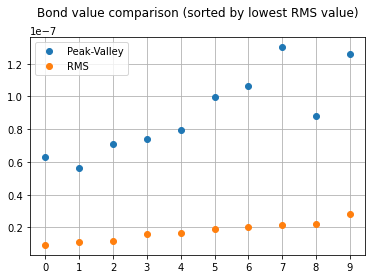

In [24]:
#brief comparison/display of values, sorted
#note, keeping order for both based on lowest rms, to compare both values between combo
plt.plot(pvValues[rmsValues.argsort()], "o", label="Peak-Valley")
plt.plot(rmsValues[rmsValues.argsort()], "o", label="RMS")
plt.title("Bond value comparison (sorted by lowest RMS value)\n")

plt.xticks(range(len(mpairs)))
# yi = plt.ylim()
# plt.ylim(yi[0]/100, yi[1]/100)
plt.legend()
plt.grid()
plt.show()

In [25]:
lowestrms = mpairs[rmsValues.argsort()]

print("Sample Bonds sorted by lowest RMS height:\n")
for i in range(len(lowestrms)):
    combo = lowestrms[i]
    print("{} - ".format(i+1),*[m.filename for m in combo])
    print("RMS Height:", rmsValues[rmsValues.argsort()][i])
    print("Peak-to-valley Height:", pvValues[rmsValues.argsort()][i])
    print("\n")

Sample Bonds sorted by lowest RMS height:

1 -  C1.txt M1.txt
RMS Height: 9.307477002183646e-09
Peak-to-valley Height: 6.310479788824831e-08


2 -  A2.txt M1.txt
RMS Height: 1.099653554079312e-08
Peak-to-valley Height: 5.6054719922962034e-08


3 -  A2.txt C1.txt
RMS Height: 1.172619529329596e-08
Peak-to-valley Height: 7.091363270193264e-08


4 -  M1.txt M2.txt
RMS Height: 1.5759942379783684e-08
Peak-to-valley Height: 7.423417133032746e-08


5 -  C1.txt M2.txt
RMS Height: 1.6844008383871412e-08
Peak-to-valley Height: 7.979798317387877e-08


6 -  A1.txt M1.txt
RMS Height: 1.8763732935725955e-08
Peak-to-valley Height: 9.950886502060442e-08


7 -  A1.txt A2.txt
RMS Height: 2.0489603383499043e-08
Peak-to-valley Height: 1.0610529192970452e-07


8 -  A1.txt C1.txt
RMS Height: 2.1642853021437312e-08
Peak-to-valley Height: 1.3008871876603995e-07


9 -  A2.txt M2.txt
RMS Height: 2.1936091741256755e-08
Peak-to-valley Height: 8.82452045843477e-08


10 -  A1.txt M2.txt
RMS Height: 2.841472918965907

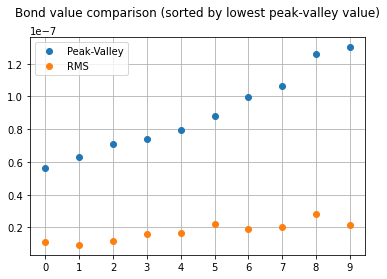

In [26]:
plt.plot(pvValues[pvValues.argsort()], "o", label="Peak-Valley")
plt.plot(rmsValues[pvValues.argsort()], "o", label="RMS")
plt.title("Bond value comparison (sorted by lowest peak-valley value)\n")

plt.xticks(range(len(mpairs)))
# yi = plt.ylim()
# plt.ylim(yi[0]/100, yi[1]/100)
plt.legend()
plt.grid()
plt.show()

In [27]:
#contact points - want to find 3 points of contact of upper surface placed on lower surface
#2 ideas: 
#1) - use 3 lowest points in interface to form a plane, which can give the necessary rotation angle of upper surface
#2) - find the lowest point in interface as initial contact. 
#   - The upper surface will rotate down towards the centre of gravity (centre of circle) into x-y plane
#   - following the position vector from centre - i.e. the axis of rotation is the tangent to this position vector
#   - then, rotate until another point meets surface - this point along with the initial gives a new axis of rotation
#   - perform again for 3rd point
#1st idea simpler/faster, 2nd idea probably more realistic

In [28]:
m1,m2 = matchdims(zmaps[0].heights, zmaps[1].heights)
interface = -m1 + m2

In [29]:
np.nanmin(interface)

-8.223437181321835e-08

In [30]:
#get row,column index for the location of the minimum (first contacting point)
#if this happens to be more than one point, can skip to using the axis between these points to rotate (?)
np.where(interface == np.nanmin(interface))

(array([39]), array([6]))

In [31]:
interface[39,6]

-8.223437181321835e-08

In [32]:
centre = [interface.shape[0]//2, interface.shape[1]//2]
centre

[35, 35]

In [33]:
contactpoint = [int(_) for _ in np.where(interface == np.nanmin(interface))]
contactpoint

[39, 6]

In [34]:
radialvec = [contactpoint[i] - centre[i] for i in range(2)]
radialvec

[4, -29]

In [35]:
#rotation axis, perpendicular to the vector of point measured from centre and the z-axis
#i.e. looking for axis vector also in x-y plane
#easier to use axis = [-y,x] (cross product overkill for 2 vectors in plane)
axis = np.cross(radialvec, np.array([0,0,1]))
axis

array([-29,  -4,   0])

In [36]:
np.dot(radialvec, -axis[:-1])

0

In [37]:
r = Rot.from_rotvec(np.pi/2*axis)

In [38]:
#not sure how to define angle accurately
#maybe it's not that important at these levels, since we only need to know the first point in negatives
np.linspace(1e-12, 1e-10, 100)[:20]

array([1.0e-12, 2.0e-12, 3.0e-12, 4.0e-12, 5.0e-12, 6.0e-12, 7.0e-12,
       8.0e-12, 9.0e-12, 1.0e-11, 1.1e-11, 1.2e-11, 1.3e-11, 1.4e-11,
       1.5e-11, 1.6e-11, 1.7e-11, 1.8e-11, 1.9e-11, 2.0e-11])

In [39]:
#get 1st contact point from centre
contactpoint = [int(pt) for pt in np.where(interface == np.nanmin(interface))]
centre = [interface.shape[0]//2, interface.shape[1]//2]

#axis orthogonal to radial position vector in x-y plane
radialvec = np.array([contactpoint[i] - centre[i] for i in range(2)])
axis = np.array([-radialvec[1], radialvec[0], 0])
angle = 1.576e-11

array = interface
# array = zmaps[1].heights
array += abs(np.nanmin(array))  # - set minimum point to zero height (remove negative)
dims = array.shape
x,y = np.indices(dims)

vectarray = np.dstack([x,y,array])
vectarray = vectarray.reshape(int(vectarray.size/3), 3)

#use angle step size (chose 10^-12 but could be different ?)
ang = 1e-14
angles = []
contacts = [contactpoint]
newarray = vectarray.copy()
for j in range(2):
    #for 3rd contact point, use the axis between the two found points so far
    if len(contacts) == 2:
        axis = np.array([*[contacts[0][i] - contacts[1][i] for i in range(2)], 0])
    
    i = 0
    r = Rot.from_rotvec((ang)*axis)
    while True:
        i += 1
        
        newarray = r.apply(newarray)
        
        if np.nanmin(newarray[:,2]) < 0:
            newheights = newarray[:,2].reshape(dims)
            minpoints = [int(pt) for pt in np.where(newheights == np.nanmin(newheights))]
            nextpoint = [pt for pt in minpoints if pt not in contacts]
            
            
            if nextpoint in contacts:
#                 ang *= 1e-1
                continue
            
            if nextpoint:
                angles.append((i-1)*ang)
                contacts.append(nextpoint)
                
                #approximate found points to nan so they can't rotate and be found again as negatives
                #not possible to rotate to an exact zero, so just choose this for purposes of loop
                newheights[contacts[j][0],contacts[j][1]] = np.nan
                newarray[:,2] = newheights.ravel()
                break
            else:
                continue
            
        elif i*angle > 1e-06:
            #use a maximum rotation as escape (avoid infinite loops)
            #if nothing found using rotation near zero, then there is a significant gap (not flat array)
            #maybe a better way to do this or avoid while loop altogether ?
            break
            

In [40]:
[interface[contacts[i][0],contacts[i][1]] for i in range(len(contacts))]

[0.0, 6.92933277431388e-10, 1.1701864351301585e-09]

In [41]:
ang = 0
r = Rot.from_rotvec(1*ang*axis)
np.nanmin(r.apply(newarray)[:,2])

-6.3656035648704806e-09

In [42]:
int(interface[40,4])

0

In [43]:
newheights[np.where(newheights < 0)]

array([-1.98702253e-10, -9.36328713e-10, -8.43041216e-11, -1.68129337e-09,
       -5.68931895e-10, -5.14417215e-10, -4.60032277e-10, -1.38111821e-09,
       -1.84838334e-09, -1.11833402e-09, -2.52220804e-09, -3.05171411e-10,
       -2.06435973e-09, -1.29568736e-09, -4.54381187e-09, -2.09503696e-09,
       -1.54844711e-09, -4.51839422e-09, -2.74552263e-09, -4.95082487e-09,
       -3.12001871e-09, -1.54991812e-09, -4.65333594e-09, -3.86327343e-09,
       -4.21466942e-09, -3.20839158e-09, -1.94727536e-09, -4.94447980e-09,
       -4.16786162e-09, -4.39373271e-09, -2.85259940e-09, -2.71155154e-09,
       -6.12566369e-09, -5.56941808e-09, -4.21174424e-09, -2.21679014e-09,
       -2.13367685e-09, -8.43593349e-10, -1.70479583e-09, -5.34880657e-09,
       -4.15528068e-09, -3.45419865e-09, -2.76277237e-09, -5.36079983e-10,
       -5.51442552e-09, -2.52492796e-09, -4.45986887e-09, -1.15173117e-09,
       -6.36560356e-09, -2.94159672e-09, -4.57720902e-09, -1.05664456e-09,
       -9.30880726e-10, -

In [44]:
contacts

[[39, 6], [40, 4], [44, 5]]

In [45]:
#extracted 3 points seemingly OK
#but angles are inaccurate, they give many points beneath the surface

In [46]:
angles

[1.574e-11, 7.577e-11]

In [47]:
np.array([*[(contacts[0][i] - contacts[1][i]) for i in range(2)], 0])

array([-1,  2,  0])

In [48]:
np.where(newheights == np.nanmin(newheights))

(array([44]), array([5]))

In [49]:
np.nanmin(vectarray[:,2])

0.0

In [50]:
np.nanmin(newarray)

-6.3656035648704806e-09

In [51]:
#attempt 2: just to clear things up somewhat
m1,m2 = matchdims(zmaps[0].heights, zmaps[1].heights)
interface = -m1[::-1] + m2  # - need to fix for m1 flipped (and then smarter selection of angles)

#get 1st contact point from centre
contactpoint = [int(pt) for pt in np.where(interface == np.nanmin(interface))]
centre = [interface.shape[0]//2, interface.shape[1]//2]

#axis orthogonal to radial position vector in x-y plane
radialvec = np.array([contactpoint[i] - centre[i] for i in range(2)])
axis = np.array([-radialvec[1], radialvec[0], 0])
if np.prod(axis[:-1]) < 0:
    axis = -axis

#rotating upper array w.r.t its zero plane (preset to have min. at zero before rotation)
#need to apply checks with m2 placed onto m1 (flipped and negative) to determine actual contact
#(?)
array = interface.copy()

#set initial contact to nan (avoid re-detecting when using np.nanmin)
# array[contactpoint[0],contactpoint[1]] = np.nan
array += abs(np.nanmin(array))  # - set minimum point to zero height (remove negative)
dims = array.shape
x,y = np.indices(dims)

offset = contactpoint  # - to centre on the contact point, will subtract this offset
# vectarray = np.dstack([x-offset[0],y-offset[1],array])
vectarray = np.dstack([x,y,array])
vectarray = vectarray.reshape(int(vectarray.size/3), 3)


#######################
#now perform rotations:
#######################
# ang = np.pi/4  # - start with fairly large angle and reduce down as required (?)
#seems to require angle on same order as peak-valley measurement, or else the rotation effect is too significant
totalang = 0
angles = []
contacts = [contactpoint]

newarray = vectarray.copy()

i = 0
tol = np.nanmax(interface)*1e-2  # - is it sensible to define tolerance as fraction (i.e. 1/100) of peak-valley height?

for j in range(2):
    if len(contacts) == 2:
        axis = np.array([*[contacts[0][i] - contacts[1][i] for i in range(2)], 0])
        #adjust to centre rotation on midpoint of axis
        midpoint = contacts[0] + axis[:-1]/2
#         offset = (contactpoint - midpoint)
#         newarray[:,0] += offset[0]  # - adding back the previous offset, moving to new centre at midpoint
#         newarray[:,1] += offset[1]
        if np.prod(axis[:-1]) < 0:
            #adjust for clockwise/anti-clockwise rotation (anti-clockwise used as default for scipy Rotation)
            axis = -axis
    
    ang = np.pi/4  # - start with fairly large angle size and adjust down as required
    i = 0
    while True:  # - use while True ... break as "do...while" loop
        i += 1
        #rotate until a new negative minimum is found
        #apply one rotation of set angular step (not sure how to choose ?)
        #check position of minimum: above axis, below surface
        #can introduce a tolerance level to be considered at surface
        #base on angle size (?)
        #if point in the bounds above axis, need to reduce to a smaller angle step for more accuracy
        #then proceed until negative
        #if point in the bounds below axis, take as contact point at angle = multiple of iteration

        r = Rot.from_rotvec(ang*axis)
        newarray = r.apply(newarray)
        totalang += ang
        
        #adding interface creation: need to be able to compare rotated surface to the lower surface
        #rather than just using the flat plane
        #newheights = newarray[:,2].reshape(dims)
#         newarray[:,0] += offset[0]
#         newarray[:,1] += offset[1]
        newvalid = newarray.copy()  # - retain unrounded vectors for accuracy of future iterations
        newvalid[:,0] = np.round(newvalid[:,0])
        newvalid[:,1] = np.round(newvalid[:,1])
        newvalid = newvalid[(newvalid[:,0] < dims[0]) & (newvalid[:,1] < dims[1])]

        newheights = np.ones(dims) * np.nan
        newheights[newvalid[:,0].astype("int"), newvalid[:,1].astype("int")] = newvalid[:,2]
        
        iface = -m1[::-1] + newheights + abs(np.nanmin(interface))
        
        if abs(np.nanmin(iface)) > np.nanmax(array):
            #if true, the angular step is too much, since the minimum is now above the expected peak-valley height
            #reduce size and try again
            ang *= 1e-1
            i = 0
            totalang = 0
            print(11,ang, np.nanmin(iface))
            newarray = vectarray.copy()
            continue
        if i == 1:  # - run some tests on one single rotation (find the effect of the angle size)
            if np.nanmin(iface) > (0 + tol):
                #angle used is:
                # a) not large enough -> continue with this step size until meeting axis
                # b) too large, the minimum may appear somewhere far from the tolerance level (i.e. becoming tilted plane)
                print(1, ang, np.nanmin(iface))
                continue
            elif np.nanmin(iface) > 0:
                #this marks a point within tolerance on the positive side of axis
                #one angle would thus bypass the range if applied again
                #continue with smaller angle size to get more accurate intersection
                ang *= 1e-1
                print(2)
                continue
            elif np.nanmin(iface) < (0 - tol):
                #angle step size is too large, adjust down (e.g. by order of magnitude) and try again
                #resetting newarray and i
                ang *= 1e-1
                totalang = 0
                newarray = vectarray.copy()
                i = 0
                print(3, ang, np.nanmin(iface))
                continue
            elif np.nanmin(iface) >= (0 - tol):
                #the point should ideally lie in this range
                print(4)
                
        print(j,i,ang,totalang,np.nanmin(iface))
        if (np.nanmin(iface) > (0 - tol)) & (np.nanmin(iface) < 0):
            print(j,i, np.nanmin(iface))
            #newheights = newarray[:,2].reshape(dims)  # - old, inaccurate method
            
            minpoints = [int(pt) for pt in np.where(iface == np.nanmin(iface))]
            nextpoint = [pt for pt in minpoints if minpoints not in contacts]
            print(j,i, minpoints, nextpoint, contacts)
            
            

            if nextpoint:
                #found the next negative minimum
                #store the location
                #and the angle which provides closest non-negative set-up around this axis
                #note: this angle is dubious, as have used an adaptive step size
                #so just saying (i-1) multiples is not that accurate
                #would need initial angle and count number of decreases (order of magnitude each time)
                #the actual points are more important, angles/distances will always be approximate within error range
                #angles.append((i-1)*ang)  # - gives zero if i==1 (impossible) better method needed ?
                #NOTE: switched to cumulative angle counter "totalang"
                angles.append(totalang)
                contacts.append(nextpoint)

                #gone negative, so need to step back the angle for realistic physical combination (non-negative intersection)
                newarray = r.inv().apply(newarray)
                
                #just found a new contact, now set this to nan to effectively ignore this point in future iterations
                #thus these don't occur again and again when searching with np.nanmin
                #note: doing loop for all points here for simplicity - would ideally do one at a time
                #which would require setting the 1st point before the loop beginning (possible confusion)
#                 for j in range(len(contacts)):
#                     newheights[contacts[j][0],contacts[j][1]] = np.nan
                newheights[nextpoint[0],nextpoint[1]] = np.nan
                
                newarray[:,2] = newheights.ravel()
                
                break
            else:
                newheights[minpoints[0],minpoints[1]] = np.nan
                newarray[:,2] = newheights.ravel()
                continue


        if (i > 20000) | (totalang >= np.pi):
            print(i,totalang)
            break
            
##############
##############
if len(contacts) != 3:
    print("Failed to find 3 points of contact")
    
#approximate rotations already applied, so use the "newheights" array
#the contacts were set to nan values, but now can be set to (approx.) zero (within error tolerance)
else:
    for j in range(len(contacts)):
        newheights[contacts[j][0],contacts[j][1]] = 0

11 0.07853981633974483 6.349144566410054
11 0.007853981633974483 -55.69578853958266
11 0.0007853981633974484 -17.62930819511533
11 7.853981633974485e-05 -1.778766276235384
11 7.853981633974485e-06 -0.17789234868403175
11 7.853981633974485e-07 -0.017789093308082836
11 7.853981633974486e-08 -0.0017787519074564289
11 7.853981633974486e-09 -0.0001777177515309396
11 7.853981633974486e-10 -1.76143359225297e-05
11 7.853981633974486e-11 -1.6597957644901372e-06
3 7.853981633974486e-12 -1.1318970112788168e-07
1 7.853981633974486e-12 3.072233306736785e-08
0 2 7.853981633974486e-12 1.570796326794897e-11 2.4286393393207722e-08
0 3 7.853981633974486e-12 2.3561944901923456e-11 7.101881578071543e-09
0 4 7.853981633974486e-12 3.141592653589794e-11 -1.0082630237064636e-08
0 5 7.853981633974486e-12 3.926990816987243e-11 -2.7267142052200815e-08
0 6 7.853981633974486e-12 4.712388980384692e-11 -4.4451653867336994e-08
0 7 7.853981633974486e-12 5.4977871437821405e-11 -6.163616568247315e-08
0 8 7.8539816339744

0 125 7.853981633974486e-13 9.817477042468083e-11 -1.561509806657221e-07
0 126 7.853981633974486e-13 9.896016858807827e-11 -1.5786943184723573e-07
0 127 7.853981633974486e-13 9.974556675147572e-11 -1.5958788302874932e-07
0 128 7.853981633974486e-13 1.0053096491487316e-10 -1.613063342102629e-07
0 129 7.853981633974486e-13 1.013163630782706e-10 -1.6302478539177654e-07
0 130 7.853981633974486e-13 1.0210176124166804e-10 -1.6474323657329018e-07
0 131 7.853981633974486e-13 1.0288715940506549e-10 -1.6646168775480377e-07
0 132 7.853981633974486e-13 1.0367255756846293e-10 -1.6818013893631735e-07
0 133 7.853981633974486e-13 1.0445795573186037e-10 -1.69898590117831e-07
0 134 7.853981633974486e-13 1.0524335389525782e-10 -1.7161704129934463e-07
0 135 7.853981633974486e-13 1.0602875205865526e-10 -1.7333549248085822e-07
0 136 7.853981633974486e-13 1.068141502220527e-10 -1.750539436623718e-07
0 137 7.853981633974486e-13 1.0759954838545014e-10 -1.7677239484388544e-07
0 138 7.853981633974486e-13 1.08384

0 130 7.853981633974487e-14 1.0210176124166814e-11 2.989059641232995e-08
0 131 7.853981633974487e-14 1.0288715940506559e-11 2.986287185716202e-08
0 132 7.853981633974487e-14 1.0367255756846304e-11 2.983514730199409e-08
0 133 7.853981633974487e-14 1.0445795573186048e-11 2.9807422746826156e-08
0 134 7.853981633974487e-14 1.0524335389525793e-11 2.9779698191658227e-08
0 135 7.853981633974487e-14 1.0602875205865538e-11 2.9751973636490297e-08
0 136 7.853981633974487e-14 1.0681415022205282e-11 2.9724249081322368e-08
0 137 7.853981633974487e-14 1.0759954838545027e-11 2.969652452615444e-08
0 138 7.853981633974487e-14 1.0838494654884771e-11 2.966879997098651e-08
0 139 7.853981633974487e-14 1.0917034471224516e-11 2.964107541581858e-08
0 140 7.853981633974487e-14 1.099557428756426e-11 2.961335086065065e-08
0 141 7.853981633974487e-14 1.1074114103904005e-11 2.9585626305482715e-08
0 142 7.853981633974487e-14 1.115265392024375e-11 2.9557901750314785e-08
0 143 7.853981633974487e-14 1.1231193736583494e

0 263 7.853981633974487e-14 2.0655971697352974e-11 1.3460150949671891e-08
0 264 7.853981633974487e-14 2.073451151369272e-11 1.3288305831520532e-08
0 265 7.853981633974487e-14 2.0813051330032467e-11 1.3116460713369174e-08
0 266 7.853981633974487e-14 2.0891591146372213e-11 1.2944615595217815e-08
0 267 7.853981633974487e-14 2.097013096271196e-11 1.2772770477066443e-08
0 268 7.853981633974487e-14 2.1048670779051705e-11 1.2600925358915085e-08
0 269 7.853981633974487e-14 2.112721059539145e-11 1.2429080240763726e-08
0 270 7.853981633974487e-14 2.1205750411731198e-11 1.2257235122612354e-08
0 271 7.853981633974487e-14 2.1284290228070944e-11 1.2085390004460996e-08
0 272 7.853981633974487e-14 2.136283004441069e-11 1.1913544886309637e-08
0 273 7.853981633974487e-14 2.1441369860750437e-11 1.1741699768158265e-08
0 274 7.853981633974487e-14 2.1519909677090183e-11 1.1569854650006893e-08
0 275 7.853981633974487e-14 2.159844949342993e-11 1.1398009531855535e-08
0 276 7.853981633974487e-14 2.1676989309769

1 28 7.853981633974486e-12 2.1991148575128552e-10 1.3887983200273055e-07
1 29 7.853981633974486e-12 2.2776546738526e-10 1.389033939476325e-07
1 30 7.853981633974486e-12 2.356194490192345e-10 1.389269558925344e-07
1 31 7.853981633974486e-12 2.43473430653209e-10 1.389505178374363e-07
1 32 7.853981633974486e-12 2.513274122871835e-10 1.3897407978233824e-07
1 33 7.853981633974486e-12 2.59181393921158e-10 1.3899764172724018e-07
1 34 7.853981633974486e-12 2.670353755551325e-10 1.390212036721421e-07
1 35 7.853981633974486e-12 2.74889357189107e-10 1.39044765617044e-07
1 36 7.853981633974486e-12 2.827433388230815e-10 1.3906832756194594e-07
1 37 7.853981633974486e-12 2.90597320457056e-10 1.3909188950684787e-07
1 38 7.853981633974486e-12 2.9845130209103053e-10 1.3911545145174978e-07
1 39 7.853981633974486e-12 3.0630528372500504e-10 1.391390133966517e-07
1 40 7.853981633974486e-12 3.1415926535897954e-10 1.3916257534155363e-07
1 41 7.853981633974486e-12 3.2201324699295405e-10 1.3918613728645556e-07


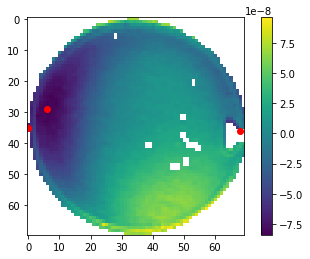

In [52]:
plt.imshow(interface)
plt.plot(0,35,"ro")
plt.plot(6,29, "ro")
plt.plot(68,36, "ro")
plt.colorbar()
plt.show()

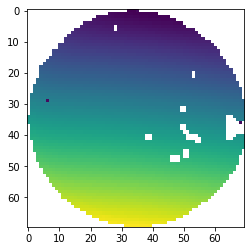

In [53]:
plt.imshow(newheights)
plt.show()

In [54]:
tol

9.640980660884048e-10

In [55]:
for j in range(len(contacts)):
    print(contacts[j], newheights[contacts[j][0],contacts[j][1]])

[29, 6] 0.0
[36, 68] 0.0
[0, 35] 0.0


In [56]:
np.where(newheights <= 0)

/local/environments/gw/gw-venv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


(array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4, 29, 36]),
 array([32, 33, 34, 35, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 47, 48,
        49,  6, 68]))

In [57]:
if nextpoint:
    print(True)

True


In [58]:
[pt for pt in minpoints if minpoints in contacts]

[0, 35]

In [59]:
minpoints

[0, 35]

In [60]:
contacts

[[29, 6], [36, 68], [0, 35]]

In [61]:
angles

[2.6860617188192926e-11, 1.2959069696057881e-09]

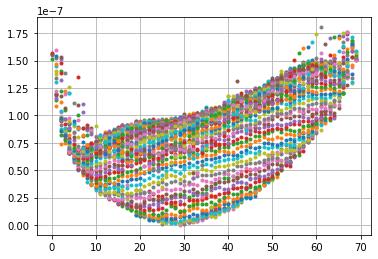

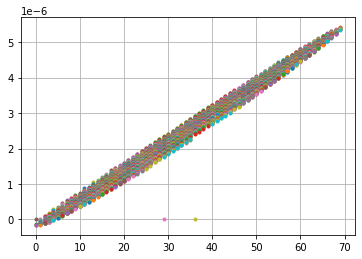

In [62]:
plt.plot(interface + abs(np.nanmin(interface)), ".")
plt.grid()
plt.show()
plt.plot(newheights, ".")
plt.grid()
plt.show()

In [63]:
print(contactpoint)
print(axis)

[29, 6]
[ -7 -62   0]


In [129]:
g = rotatepoints(m2, axis, 0, contactpoint, getheights=True)
# plt.plot(g, ".")
# plt.show()
g

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

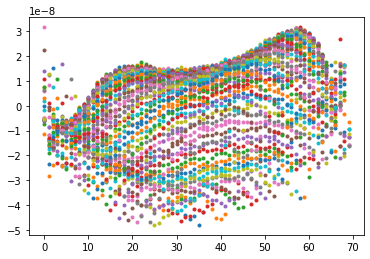

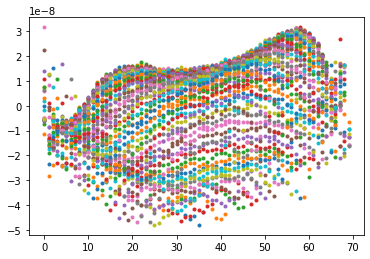

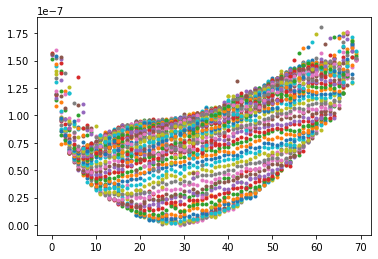

In [130]:
plt.plot(m2, ".")
plt.show()
plt.plot(g, ".")
plt.show()
plt.plot(-m1[::-1] + g + abs(np.nanmin(interface)), ".")
plt.show()

In [65]:
array = np.zeros((70,70))
dims = array.shape
centre = dims[0]//2, dims[1]//2
array[centre[0], centre[1]] = 70
array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
x,y = np.indices(array.shape)
vectarray = np.dstack([x - centre[0], y - centre[1], array])
vectarray = vectarray.reshape(vectarray.size//3, 3)
vectarray

array([[-35., -35.,   0.],
       [-35., -34.,   0.],
       [-35., -33.,   0.],
       ...,
       [ 34.,  32.,   0.],
       [ 34.,  33.,   0.],
       [ 34.,  34.,   0.]])

In [67]:
ang = np.pi/4
rt = Rot.from_rotvec(ang*np.array([0,1,0]))
newarray = rt.apply(vectarray)

newheights = newarray[:,2].reshape(dims)

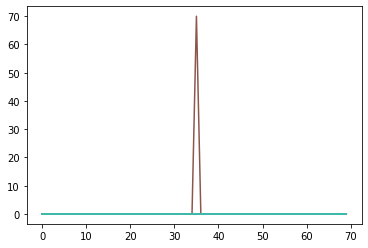

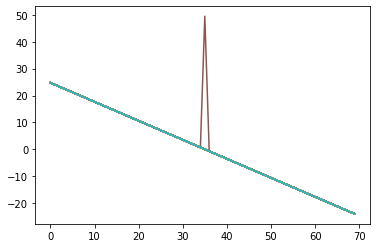

In [68]:
plt.plot(array)
# plt.plot(newheights, "b.")
plt.show()
plt.plot(newheights)
plt.show()

In [69]:
rt.apply(np.array([0,0,70]))

array([49.49747468,  0.        , 49.49747468])

In [70]:
newarray[:,2]

array([ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
       -24.04163056, -24.04163056])

In [71]:
newarray

array([[-24.74873734, -35.        ,  24.74873734],
       [-24.74873734, -34.        ,  24.74873734],
       [-24.74873734, -33.        ,  24.74873734],
       ...,
       [ 24.04163056,  32.        , -24.04163056],
       [ 24.04163056,  33.        , -24.04163056],
       [ 24.04163056,  34.        , -24.04163056]])

In [72]:
b = np.round(newarray[newarray[:,0].argsort(kind="mergesort")][newarray[:,1].argsort(kind="mergesort")])
b

array([[-25., -35.,  25.],
       [-24., -35.,  24.],
       [-23., -35.,  23.],
       ...,
       [ 23., -35., -23.],
       [ 24., -35., -24.],
       [ 49.,   0.,  49.]])

In [73]:
#add back the centring so that the [x,y] co-ordinates can be used as [i,j] matrix indexes again
b[:,0] += centre[0]
b[:,1] += centre[1]
b

array([[ 10.,   0.,  25.],
       [ 11.,   0.,  24.],
       [ 12.,   0.,  23.],
       ...,
       [ 58.,   0., -23.],
       [ 59.,   0., -24.],
       [ 84.,  35.,  49.]])

In [74]:
b[:,:-1].astype("int")

array([[10,  0],
       [11,  0],
       [12,  0],
       ...,
       [58,  0],
       [59,  0],
       [84, 35]])

In [75]:
#use the new indexes to determine the necessary size to hold these points
#e.g. a large spike may rotate outside initial grid, so adapt new array
minrows = int(np.nanmin(b[:,0]))
maxrows = int(np.nanmax(b[:,0]) + 1)

mincols = int(np.nanmin(b[:,1]))
maxcols = int(np.nanmax(b[:,1]) + 1)

In [76]:
maxsize = max(maxrows, maxcols)
newdims = (maxsize,maxsize)
newdims

(85, 85)

In [132]:
#try to insert new values to co-ordinates after rotation
#set-up new empty (or all-nan) array and set points
u = np.ones(newdims) * np.nan
u

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [133]:
u[b[:,0].astype("int"), b[:,1].astype("int")] = b[:,2]
u

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [134]:
u[b[:,0].astype("int"), b[:,1].astype("int")]

array([ 25.,  24.,  23., ..., -23., -24.,  49.])

In [135]:
b[:,2]

array([ 25.,  24.,  23., ..., -23., -24.,  49.])

In [136]:
np.where(u == np.nanmax(u))

(array([84]), array([35]))

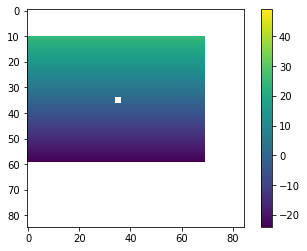

In [137]:
plt.imshow(u)
plt.colorbar()
plt.show()

In [83]:
u[35,35]

nan

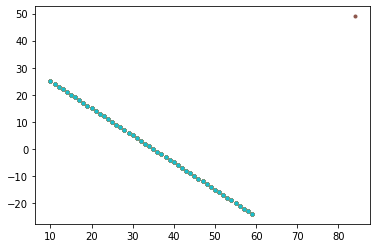

In [84]:
plt.plot(u, ".")
plt.show()

In [85]:
set(b[:,0])

{10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 84.0}

In [86]:
set(b[:,1])

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0}

In [87]:
newarray

array([[-24.74873734, -35.        ,  24.74873734],
       [-24.74873734, -34.        ,  24.74873734],
       [-24.74873734, -33.        ,  24.74873734],
       ...,
       [ 24.04163056,  32.        , -24.04163056],
       [ 24.04163056,  33.        , -24.04163056],
       [ 24.04163056,  34.        , -24.04163056]])

In [88]:
from scipy.interpolate import griddata

In [89]:
X,Y = np.meshgrid(np.arange(-35,35,1), np.arange(-35,35,1), indexing="xy")
X,Y

(array([[-35, -34, -33, ...,  32,  33,  34],
        [-35, -34, -33, ...,  32,  33,  34],
        [-35, -34, -33, ...,  32,  33,  34],
        ...,
        [-35, -34, -33, ...,  32,  33,  34],
        [-35, -34, -33, ...,  32,  33,  34],
        [-35, -34, -33, ...,  32,  33,  34]]),
 array([[-35, -35, -35, ..., -35, -35, -35],
        [-34, -34, -34, ..., -34, -34, -34],
        [-33, -33, -33, ..., -33, -33, -33],
        ...,
        [ 32,  32,  32, ...,  32,  32,  32],
        [ 33,  33,  33, ...,  33,  33,  33],
        [ 34,  34,  34, ...,  34,  34,  34]]))

In [90]:
zs = griddata((newarray[:,0], newarray[:,1]), newarray[:,2], (X,Y), method="nearest", rescale=False, fill_value=np.nan)
zs

array([[ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056],
       [ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056],
       [ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056],
       ...,
       [ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056],
       [ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056],
       [ 24.74873734,  24.74873734,  24.74873734, ..., -24.04163056,
        -24.04163056, -24.04163056]])

In [91]:
zs.shape

(70, 70)

In [92]:
max(newarray[:,2])

49.49747468305832

In [93]:
np.nanmax(zs)

24.748737341529164

In [94]:
np.nanmin(zs)

-24.041630560342618

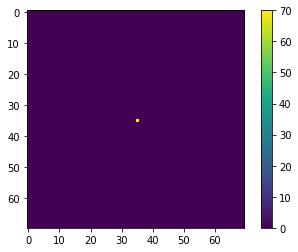

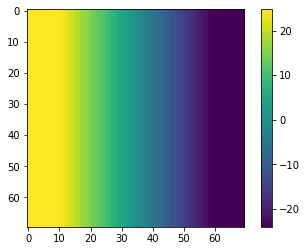

In [95]:
plt.imshow(array)
plt.colorbar()
plt.show()
plt.imshow(zs)
plt.colorbar()
plt.show()

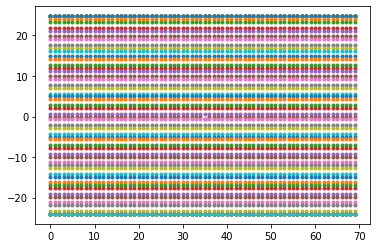

In [96]:
# plt.plot(vectarray[:,2].reshape(dims), ".")
# plt.plot(b[:,2].reshape(dims), ".")
plt.plot(zs, ".")
plt.show()

In [97]:
np.where(newarray == np.nanmax(newarray[:,2]))

(array([2485]), array([2]))

In [98]:
newarray[2485]

array([49.49747468,  0.        , 49.49747468])

In [99]:
np.where(b[:,0]==49.)

(array([  55,  125,  195,  265,  335,  405,  475,  545,  615,  685,  755,
         825,  895,  965, 1035, 1105, 1175, 1245, 1315, 1385, 1455, 1525,
        1595, 1665, 1735, 1805, 1875, 1945, 2015, 2085, 2155, 2225, 2295,
        2365, 2435, 2505, 2575, 2645, 2715, 2785, 2855, 2925, 2995, 3065,
        3135, 3205, 3275, 3345, 3415, 3485, 3555, 3625, 3695, 3765, 3835,
        3905, 3975, 4045, 4115, 4185, 4255, 4325, 4395, 4465, 4535, 4605,
        4675, 4745, 4815, 4884]),)

In [100]:
rt.apply(np.array([0,0,70]))

array([49.49747468,  0.        , 49.49747468])

In [101]:
zs.shape

(70, 70)

In [102]:
newarray[:,0].shape

(4900,)

In [103]:
print(griddata.__doc__)


    Interpolate unstructured D-D data.

    Parameters
    ----------
    points : 2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).
        Data point coordinates.
    values : ndarray of float or complex, shape (n,)
        Data values.
    xi : 2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.
        Points at which to interpolate data.
    method : {'linear', 'nearest', 'cubic'}, optional
        Method of interpolation. One of

        ``nearest``
          return the value at the data point closest to
          the point of interpolation. See `NearestNDInterpolator` for
          more details.

        ``linear``
          tessellate the input point set to N-D
          simplices, and interpolate linearly on each simplex. See
          `LinearNDInterpolator` for more details.

        ``cubic`` (1-D)
          return the value determined from a cubic
          spline.

        ``cubi

In [104]:
x,y = np.indices((70,70))
R = ((x-35)**2 + (y-35)**2)
s = (70 - R)
s

array([[-2380, -2311, -2244, ..., -2179, -2244, -2311],
       [-2311, -2242, -2175, ..., -2110, -2175, -2242],
       [-2244, -2175, -2108, ..., -2043, -2108, -2175],
       ...,
       [-2179, -2110, -2043, ..., -1978, -2043, -2110],
       [-2244, -2175, -2108, ..., -2043, -2108, -2175],
       [-2311, -2242, -2175, ..., -2110, -2175, -2242]])

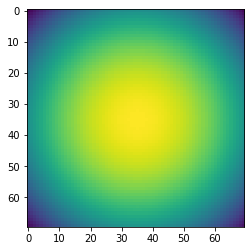

In [105]:
plt.imshow(s)
plt.show()

In [106]:
array = s.copy()
x,y = np.indices(array.shape)
vectarray = np.dstack([x - centre[0], y - centre[1], array])
vectarray = vectarray.reshape(vectarray.size//3, 3)
vectarray

array([[  -35,   -35, -2380],
       [  -35,   -34, -2311],
       [  -35,   -33, -2244],
       ...,
       [   34,    32, -2110],
       [   34,    33, -2175],
       [   34,    34, -2242]])

In [107]:
vr = rt.apply(vectarray)
vr

array([[-1707.66287657,   -35.        , -1658.16540188],
       [-1658.87250866,   -34.        , -1609.37503398],
       [-1611.49635432,   -33.        , -1561.99887964],
       ...,
       [-1467.95367774,    32.        , -1516.03693886],
       [-1513.91561852,    33.        , -1561.99887964],
       [-1561.29177286,    34.        , -1609.37503398]])

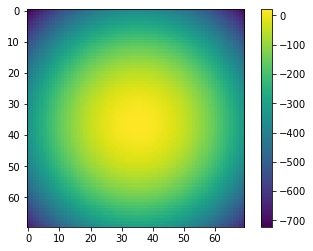

In [108]:
plt.imshow(s - vr[:,2].reshape((70,70)))
plt.colorbar()
plt.show()

In [109]:
r.__dir__()

['_single',
 '_quat',
 '__module__',
 '__doc__',
 '__init__',
 '__len__',
 'from_quat',
 'from_matrix',
 'from_dcm',
 'from_rotvec',
 'from_euler',
 'as_quat',
 'as_matrix',
 'as_dcm',
 'as_rotvec',
 'as_euler',
 'apply',
 '__mul__',
 'inv',
 'magnitude',
 'mean',
 'reduce',
 'create_group',
 '__getitem__',
 'identity',
 'random',
 'match_vectors',
 'align_vectors',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [110]:
def rotatepoints(array, axis, angle, centre=[0,0], getheights=False):
    #general function to rotate points in grid format (MxN array - each row,column index stores a height)
    #treat each value in grid as 3d point (row,column,height)
    #create stack of vectors to rotate around given axis by given angle
    #use "getheights" to specify whether to return just the stack of rotated vectors
    #or go further and re-fit these points to original grid
    
    #using simple approximation (rounding) of rotated co-ordinates to the original grid points
    dims = array.shape
    x,y = np.indices(dims)
    if len(dims) != 2:
        print("Invalid array dimensions: required shape (NxM).")
        return
    
    #adjust axis to unit vector
    magnitude = np.sqrt(axis.dot(axis))
    if (magnitude > 1.01) | (magnitude < 0.99):
        axis = axis/magnitude
    
    #construct array (stack) of position vectors, i.e. [x,y,array]
    #for each point in array by row,column and height value
    #can rotate all points at once in this way
    vectarray = np.dstack([x-centre[0],y-centre[1],array])  # - NxM (original shape) array with the 3 values at each position (i.e. NxMx3)
    vectarray = vectarray.reshape(vectarray.size//3, 3)  # - reshape to (N*M)x3 stack
    
    #define rotation
    #using scipy.spatial.transform.rotation.Rotation
    r = Rot.from_rotvec(angle*axis)
    #apply rotation to the all the finite vectors (i.e. avoiding any nan entries in z column)
    #and store in new array
    newarray = r.apply(vectarray[np.isfinite(vectarray[:,2])])
    
    #add back centre to respective column
    newarray[:,0] += centre[0]
    newarray[:,1] += centre[1]
    
    if getheights:
        #to return just the array of z values in 2D (i.e. match how "array" is input)
        #otherwise, just return the rotated array stack [x,y,z] for further consideration by user
        #new co-ordinates may lie between grid points
        #use very simple approximation
        #just round the row,column positions to the original grid, and retain the z values
        
        #NOTE: not necessary to re-order vectors if using the x,y as indices
        #direct integer indexing can be done in any order
        #while also rounding numbers to match grid index
        #note: stored as floats which can't be used to index
        #need to use .astype("int") on x,y columns to directly index arrays
        newarray[:,0] = np.round(newarray[:,0])
        newarray[:,1] = np.round(newarray[:,1])
        #only use points inside original array shape (otherwise would have to create arbitrarily larger array - problematic)
        newarray = newarray[(newarray[:,0] < dims[0]) & (newarray[:,1] < dims[1])]
        
#         newarray = np.round(newarray[newarray[:,0].argsort(kind="mergesort")][newarray[:,1].argsort(kind="mergesort")])
        
        #approximate the z values to their nearest grid point
        #note: could create resized grid based on the x,y values
        #for protection against e.g. large peaks rotating outside of grid (shouldn't apply to zygo maps (z << x,y))
        #create new grid of only nan values (for simplicity)
        newheights = np.ones(dims) * np.nan
        #then, directly set values using the x & y columns to index
        newheights[newarray[:,0].astype("int"), newarray[:,1].astype("int")] = newarray[:,2]
        
        return newheights
    else:
        return newarray

In [111]:
#using grid point rounding approximation works fine for x/y axis rotations
#around z, there is significant data losses leaving gaps - use scipy.interpolate.griddata
#will manage to interpolate new co-ordinate values (x,y) to new grid
#for simplicity, use same grid (x,y = np.indices(dims))
#can use np.meshgrid, but I have encountered issues (unpredictable, crashing etc.)
#may need to shift around centre ?

In [112]:
u = rotatepoints(zmaps[0].heights, np.array([0,0,1]), np.pi/4, centre=[35,35], getheights=True)
u

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

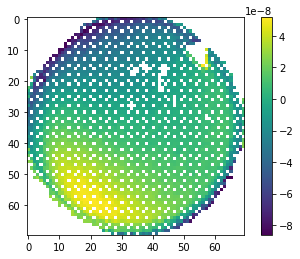

In [113]:
plt.imshow(u)
plt.colorbar()
plt.show()

In [114]:
# %%timeit
ar = rotatepoints(zmaps[0].heights, np.array([1,1,0]), np.pi/4, centre=[35,35], getheights=True)
ar

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

"858 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)"

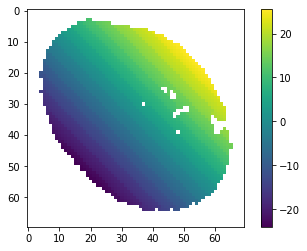

In [115]:
plt.imshow(ar)
plt.colorbar()
plt.show()

In [116]:
vt = rotatepoints(zmaps[0].heights, np.array([0,0,1]), np.pi/4, centre=[35,35], getheights=False)
vt

array([[ 1.94436508e+01,  1.05887450e+00,  2.70467150e-08],
       [ 1.87365440e+01,  1.76598128e+00,  6.17013564e-11],
       [ 1.80294373e+01,  2.47308807e+00, -2.19216277e-08],
       ...,
       [ 6.04558441e+01,  5.76274170e+01, -7.77844500e-08],
       [ 5.97487373e+01,  5.83345238e+01, -7.73374446e-08],
       [ 5.90416306e+01,  5.90416306e+01, -7.74408175e-08]])

In [117]:
# %%timeit
# A,B = np.meshgrid(*np.indices(dims), indexing="ij")  
#avoid using (A,B) as target grid, makes kernel hang completely (but I don't know why)

#use (x,y) (from np.indices(dims)) - this should actually be no different but one works, other doesn't
n = griddata((vt[:,0], vt[:,1]), vt[:,2], (x,y), method="linear")
n

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

simple rounding: "858 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)"

griddata interpolation: "126 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)"

In [118]:
#i.e. griddata much slower
#preferable to use simple rounding, but must use griddata for z-axis rotations, to avoid missing data from rounding
#simple method is ok for x/y rotations, as z values are unrestricted by grids
#thus, as long as no z component in rotation axis, the simple method can be used
#would mean ndimage.rotate not necessary for z-axis, as long as griddata gives good results

In [119]:
# %%timeit
l = scipy.ndimage.rotate(zmaps[0].heights, 45, order=0, reshape=False, mode="constant", cval=np.nan)
l

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

"362 µs ± 804 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)"

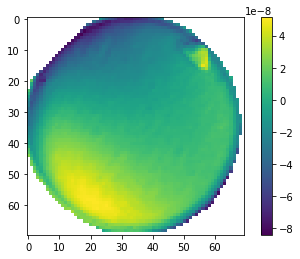

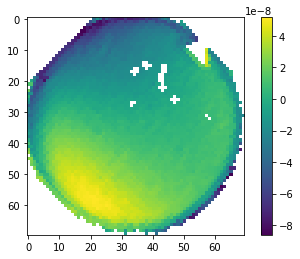

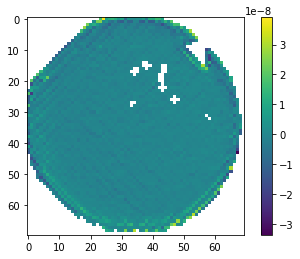

In [124]:
#comparing griddata interpolated output vs ndimage.rotate interpolated ouput
#see some clear differences, actually on order of magnitude of array values
plt.imshow(n)
plt.colorbar()
plt.show()
plt.imshow(l)
plt.colorbar()
plt.show()

plt.imshow(n - l)
plt.colorbar()
plt.show()

In [121]:
#there is significant time save by using ndimage.rotate over griddata
#however, note that griddata is more general interpolation, so can handle whichever rotated vectors you supply it
#whereas ndimage.rotate can only operate in x-y plane
#suggest using a check to see if the x & y components of axis are zero, then can safely use ndimage
#for zygo map usage, there should actually be no need for any rotations using all 3 axes
#thus, griddata should never be needed but can include for robustness (?)

In [122]:
#observe difference by using griddata interpolation of points
#angle = 0, should be as close as possible
vo = rotatepoints(zmaps[0].heights, np.array([0,0,1]), 0, centre=[35,35], getheights=False)
o = griddata((vo[:,0], vo[:,1]), vo[:,2], (x,y), method="linear")
o

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

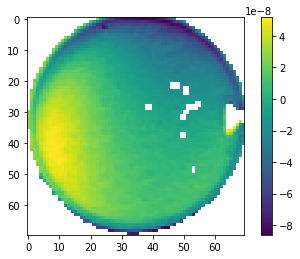

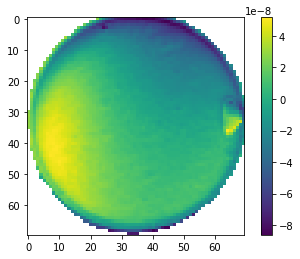

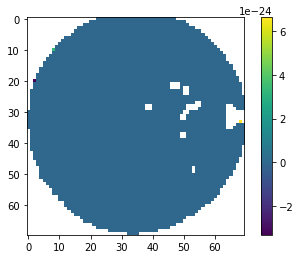

In [123]:
plt.imshow(zmaps[0].heights)
plt.colorbar()
plt.show()
plt.imshow(o)
plt.colorbar()
plt.show()

#difference
plt.imshow(zmaps[0].heights - o)
plt.colorbar()
plt.show()